In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Import data and some preprocessing
### a. convert to date time
### b. extract D and W from the group name 
### c. extract when the emails are sent for the two groups

In [2]:
df_control_groups_rate = pd.read_csv('control_groups_rate.csv')#12 control groups; what we are going to compare with. H nulls
df_treatment_groups = pd.read_csv('sample_segment_groups.csv')#12 treatment groups, how the groups are divided
df_email_order = pd.read_csv('sample_uuid_email_order.csv')#sample_uuid_email
events = pd.read_csv('user_events.csv')#sample_uuid_email_order
starting_day = pd.to_datetime('2020-11-30')
events['first_funded_at'] = pd.to_datetime(events['first_funded_at'])
events['first_linked_bank_account_at'] = pd.to_datetime(events['first_linked_bank_account_at'])
events['email_strat'] = events['group_name'].apply(lambda x: x[-1])

In [117]:
time_D = []
time_W = []
itv = [4,3]
dfw = 0
for i in range(10):
    time_D.append((starting_day + pd.DateOffset(days=i)).date())
    time_W.append(starting_day + pd.DateOffset(days=dfw))
    if i % 2 == 0:
        dfw += itv[0]
    else:
        dfw += itv[1]

In [4]:
email_names = ['ml_funding_enables_investing','ml_investing_starts_here','ml_explore_the_app_investing',           'ml_funding_faq','ml_user_clustering_emails_fracs','ml_funding_is_safe','ml_picking_an_investment',          'ml_investing_101','ml_diversified_portfolio','ml_explore_the_app_list']


# ***Goal: Better fund rate through sending emails.*** #
### - Along the way, we need to examine metrics/situations from the upper and middle funnel such as link rate or email open rate. ###
### - More importantly, analyzing any plausible signal of order of emails sent and relative strength of each email,  therefore offering advice for future stategies ###

# EDA

### Important to note that the latest an account is funded is on the 18th although the experiment for sending two emails each week go on for two more weeks after the 18th, ***evidencing daily emails are likely more effective*** ###

In [175]:
events.describe()

,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email,opened_count
count,15187,247268,148497.000000,72651.000000,244177.000000,156527.000000,74910.000000,46882.000000,480000.000000,480000.000000
mean,2020-12-06 15:56:29.103523328,2020-02-24 02:12:14.187300352,179.088301,131.875927,177.866349,121.069953,275.256268,133.785163,7.110188,2.889813
min,2020-11-28 05:15:23.243000,2014-09-18 05:39:16.885000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2020-12-01 15:44:57.971500032,2020-02-05 16:09:07.506749952,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,6.000000,1.000000
50%,2020-12-05 01:50:37.438000128,2020-06-12 12:57:07.749499904,16.000000,15.000000,30.500000,19.142857,16.000000,15.000000,8.000000,2.000000
75%,2020-12-10 18:28:58.148999936,2020-09-01 23:51:45.290749952,82.800000,72.000000,148.944444,95.000000,84.000000,57.000000,9.000000,4.000000
max,2020-12-18 08:37:53.291000,2020-12-18 08:00:04.948000,45722.200000,20615.000000,46546.842105,20615.000000,70383.000000,25007.000000,10.000000,10.000000
std,NaN,NaN,768.548805,445.125627,563.940604,333.024589,1260.624603,541.073489,3.121877,3.121877


In [179]:
events.isnull().sum()
#sparse data in terms of whether it is funded or has activities recently

user_uuid                               0
group_name                              0
ml_funding_enables_investing        60286
ml_investing_starts_here            61360
ml_explore_the_app_investing        61113
ml_funding_faq                      61209
ml_user_clustering_emails_fracs     61596
ml_funding_is_safe                  60741
ml_picking_an_investment            61181
ml_investing_101                    61533
ml_diversified_portfolio            60913
ml_explore_the_app_list             61712
approved_at                             0
first_funded_at                    464813
first_linked_bank_account_at       232732
5d_trading_avg_event_count         331503
2d_non_trading_avg_event_count     407349
20d_trading_avg_event_count        235823
8d_non_trading_avg_event_count     323473
1d_trading_avg_event_count         405090
1d_non_trading_avg_event_count     433118
num_received_email                      0
email_strat                             0
opened_count                      

### Control Group Sample Size Varies a Lot: ###
#### Accounts with many activities are limited ####


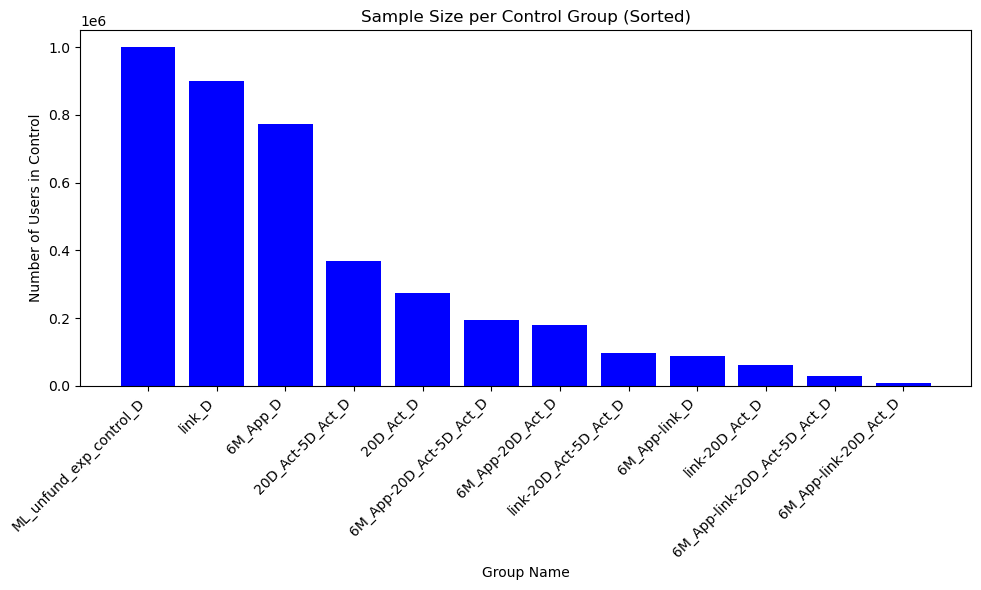

In [5]:
df_sorted = df_control_groups_rate.sort_values(by='num_users_in_control', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(df_sorted['group_name'], df_sorted['num_users_in_control'], color='blue')
plt.title('Sample Size per Control Group (Sorted)')
plt.xlabel('Group Name')
plt.ylabel('Number of Users in Control')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [265]:
df_sorted[['group_name', 'num_users_in_control']]

,group_name,num_users_in_control
8,ML_unfund_exp_control_D,1000000
11,link_D,901341
7,6M_App_D,774827
0,20D_Act-5D_Act_D,369786
1,20D_Act_D,274921
2,6M_App-20D_Act-5D_Act_D,193445
3,6M_App-20D_Act_D,178938
9,link-20D_Act-5D_Act_D,96513
6,6M_App-link_D,87008
10,link-20D_Act_D,62541


### Experiment group mostly likely over-represented accounts that are linked in the population

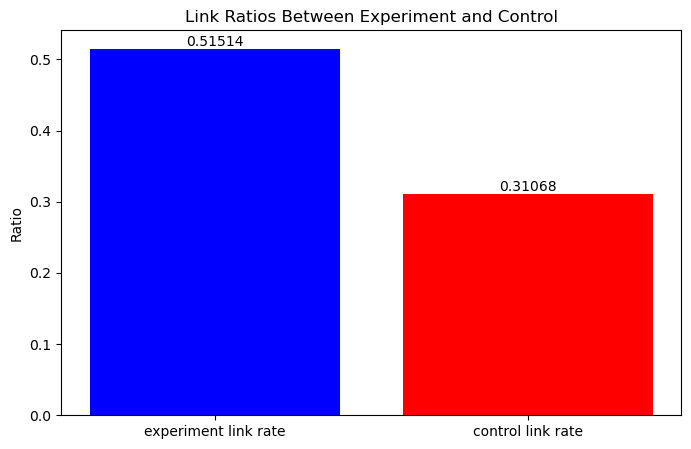

In [180]:
experiment_link_rate = events[events['first_linked_bank_account_at'].notnull()].shape[0]/events.shape[0]
control_link_rate = df_control_groups_rate['num_link_in_control'].sum()/df_control_groups_rate['num_users_in_control'].sum()
ratios = [experiment_link_rate, control_link_rate]
labels = ['experiment link rate', 'control link rate']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, ratios, color=['blue', 'red'])


plt.title('Link Ratios Between Experiment and Control')
plt.ylabel('Ratio')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 5), ha='center', va='bottom')


## 1. **Email Engagement Metrics**
- **Email Click-Through Rate (CTR):** 
  - Measure the percentage of users who clicked open the emails.


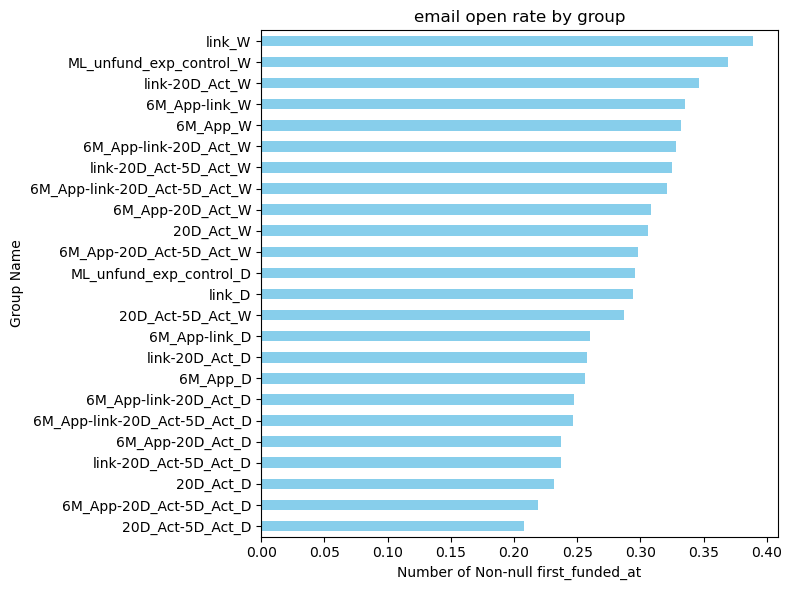

In [6]:
events['opened_count'] = 10 - events['num_received_email']
ECR = events.groupby('group_name')['opened_count'].mean().sort_values()/10
plt.figure(figsize=(8,6))
ECR.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Non-null first_funded_at')
plt.ylabel('Group Name')
plt.title('email open rate by group')
plt.tight_layout()
plt.show()

## ***Important to note: Weekly emails are read more and cause less frictions to the app which is demonstrated later. However, it is also shown later that read rate does not correspond with fund and link rate. Although read more, it does achieve the goal of improving fund rate considering its lower friction. From a utilitarian perspective, sending emails by day is more effective. More evidence to come.*** ##

## Email Open Rate for Different Emails
### - Is the most effective emails are opened frequently? 
### - Also some friction analysis
### - Possible response to eamils are nan, open, delivered, spamreport, unsubscribe

In [7]:
events['ml_diversified_portfolio'].unique()

array([nan, 'open', 'delivered', 'spamreport', 'unsubscribe'],
      dtype=object)

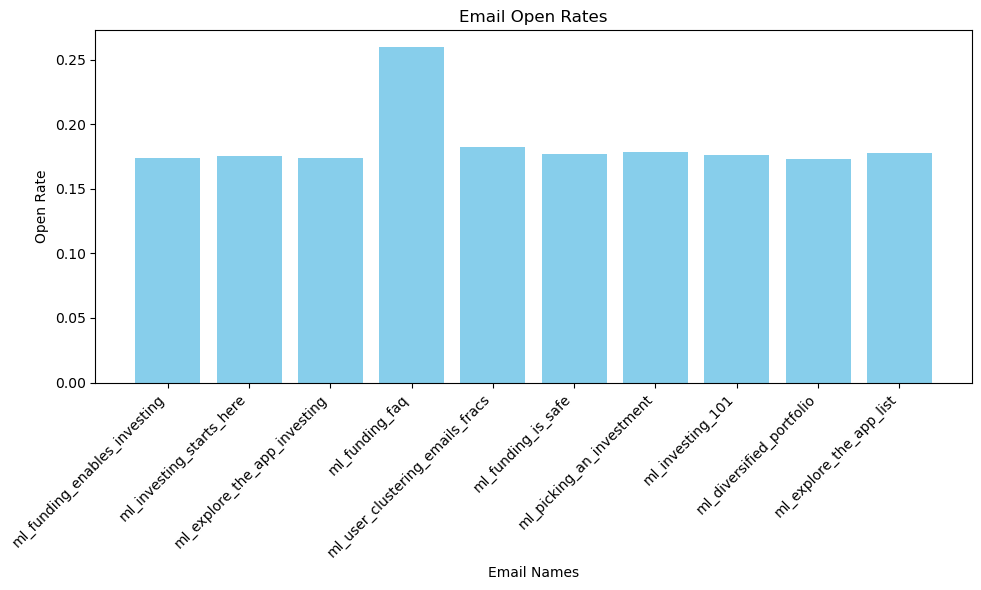

In [50]:
open_rates = {}
for name in email_names:
    open_rates[name] = events[events[name] == 'open'][name].size/events[(events[name].notnull())][name].size
plt.figure(figsize=(10, 6))
plt.bar(open_rates.keys(), open_rates.values(), color='skyblue')
plt.xlabel('Email Names')
plt.ylabel('Open Rate')
plt.title('Email Open Rates')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()

### ***A clear winner in open rate is frequenty asked questions, which signal that pertainance to the users drives the most read.***
***We will then look at whether read rate induces a user to link and fund? (Not really)***

## Is the first email opened the most? Not really...

In [11]:
(pd.Series(events['user_uuid']) == pd.Series(df_email_order['user_uuid'])).sum()#user id in the two tables are matched

480000

In [ ]:
df_status = []
for i in range(events.shape[0]):
    res = {}
    for j in range(10):
        curr_ord = f"order_{j}"
        curr_status = events.iloc[i][email_names[df_email_order.iloc[i][curr_ord]]]
        res[curr_ord] = curr_status
    df_status.append(res) 
df_status=pd.DataFrame(df_status) 

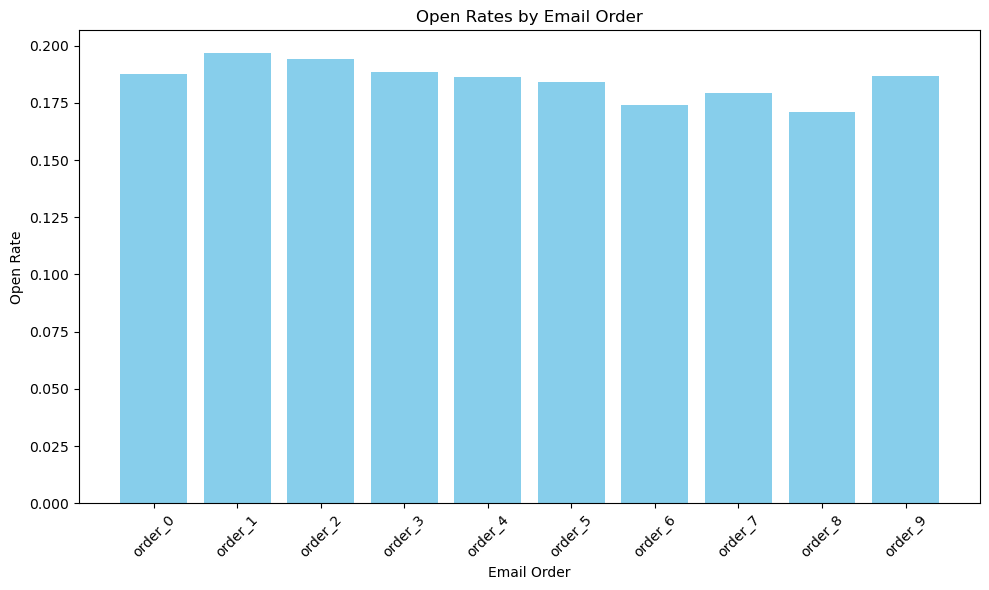

In [51]:
open_rates = {}

# Iterate through each column (order_0 to order_9)
for order in df_status.columns:
    delivered_count = df_status[(df_status[order].notnull())][order].size  # Count delivered emails
    open_count = df_status[order].str.contains('open', na=False).sum()  # Count open emails
    
    open_rate = open_count / delivered_count
    
    open_rates[order] = open_rate

plt.figure(figsize=(10, 6))
plt.bar(open_rates.keys(), open_rates.values(), color='skyblue')
plt.xlabel('Email Order')
plt.ylabel('Open Rate')
plt.title('Open Rates by Email Order')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***open rate for the ten emails ranges from 15% to 20% peaking on the second day about 19% and taperring off in the folloing days***

## Chi-squre test: Is this pattern actually statiticallt significant? (The pattern of peaking on the second day and then taper off)

In [182]:
melted_df = df_status.melt(var_name='Order', value_name='Status')
contingency_table = pd.crosstab(melted_df['Order'], melted_df['Status'])
# Perform the Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p_val}")

Chi-Square Statistic: 1855.2803138960717
Degrees of Freedom: 27
P-Value: 0.0


### ***chi-square test tells the two catagortical variables email order and status of the emails are not independent.*** ###

### ***That is, after know what the most effective email is at making a fund happen, we should put it on the second day so that more people would open it.*** ###
### Thus, we analyze which email is the most effective. 
### - We leverage the ease of feature importance of a linear regression model. We don't use the regression model for prediction. We fit it to the entire experiment group and see which email on which day is the most important in drive a success. 


## ***Problem Formulation***
- ***Y matrix/output matrix : nx10***
    - **Each output/y is going to be a 1x10 vector. Each entry would represent the ith day between 11/30 and 12/09. The y space would be accounts in experiment that either converted between 11/30 and 12/09 or never converted.**
    - **Those that never converted will be a vector of 0s; those that converted between 11/30 and 12/09 will have 1 in the corresponding index and 0s elsewhere**
- ***X matrix/input matrix : nx10x10***
    - **Each input/x will be a 10x10 matrix. Each 1x10 vector will represent the email that was sent on a given day. For example, if on the ith day betwewen 11/30 and 12/09 the jth email is sent, X[i][j] = 1 and all other entries of X[i] will be 0.**
    - **X eventually is flattened to be nx100 to be fed into a linear regression**
- ***After the model is trained, the shape of the coefficients will be (10, 100) for 10 outputs and 100 features (flattened 10x10) and it is then average on axis = 0(vertically) to get 100 average feature importances***
- ***By construction of our problem, the ith average feature importance is interpreted in the following way:***
    - **<span style="color:#FF9999">On day i//10, the ability for the (i%10)th email to drive a version is quantified as the average feature importance relative to the other emails</span>**

In [145]:
#Y : nx10
def generate_y(x):
    y = np.zeros(10)
    if pd.isnull(x):
        return y
    y[time_D.index(x.date())] = 1
    return y
events_D = events[(events['email_strat'] == 'D') & (((pd.to_datetime('2020-11-30')<events['first_funded_at']) & (events['first_funded_at']< pd.to_datetime('2020-12-10'))|(events['first_funded_at'].isnull())))]
Y = np.vstack(events_D['first_funded_at'].apply(generate_y))
Y.shape


(237206, 10)

In [185]:
Y[0]#first user's never converted

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [144]:
#X: nx10x10
def generate_x(x):
    res = []
    for i in range(10):
        k = np.zeros(10)
        order = f"order_{i}"
        k[x[order]] = 1
        res.append(k)
    return res
X = np.array(df_email_order.iloc[events_D.index].apply(generate_x, axis=1).tolist())
X.shape

(237206, 10, 10)

In [187]:
X[0]#first user's email received on the first day is the 6th email

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

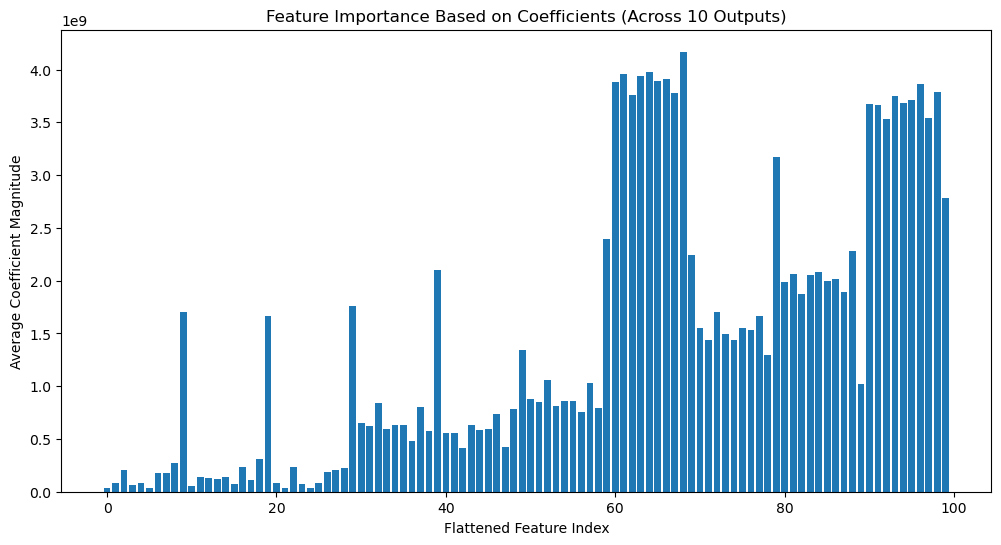

In [191]:
n_samples = X.shape[0]
X_reshaped = X.reshape(n_samples, -1)  # Flatten the last two dimensions (10x10 = 100)
model = LinearRegression()
model.fit(X_reshaped, Y)
coefficients = model.coef_  # Shape will be (10, 100) for 10 outputs and 100 features (flattened 10x10)

# To get the average importance of each feature across all 10 outputs:
average_importance = np.mean(np.abs(coefficients), axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(len(average_importance)), average_importance)
plt.xlabel("Flattened Feature Index")
plt.ylabel("Average Coefficient Magnitude")
plt.title("Feature Importance Based on Coefficients (Across 10 Outputs)")
plt.show()
reshaped_importance = average_importance.reshape(10, 10)

In [194]:
for i in range(10):
    max_ = max(enumerate(average_importance[i*10:(i+1)*10]), key=lambda x: x[1])
    min_ = min(enumerate(average_importance[i*10:(i+1)*10]), key=lambda x: x[1])
    print('the best email to send on day',i+1,'is',max_[0]+1, 'and the worst is',min_[0]+1) 

the best email to send on day 1 is 10 and the worst is 1
the best email to send on day 2 is 10 and the worst is 1
the best email to send on day 3 is 10 and the worst is 5
the best email to send on day 4 is 10 and the worst is 7
the best email to send on day 5 is 10 and the worst is 3
the best email to send on day 6 is 10 and the worst is 7
the best email to send on day 7 is 9 and the worst is 10
the best email to send on day 8 is 10 and the worst is 9
the best email to send on day 9 is 9 and the worst is 10
the best email to send on day 10 is 7 and the worst is 10


In [263]:
email_names[-1]

'ml_explore_the_app_list'

# ***Conclusion***:
### The 4th email although read the most it doesn't convert users to be funded.
### Across the 10 days the best email to send is email 10. However, this advantage is the most clear in the first 4 days as we see a dwindling peak in those days. Because the feature importance in the first 4 days are generally very low except for when the 10th email is sent, we say that on the first four days, It's better to send the 10th email on the second day, combined with our conclusion from the previous section that the second day gets the most open rate. It is also shown from the feature importance plot that on the seventh and 10th day we get the most funding conversions. In those two days there doesn't seem to be a clear winner between the 10 emails. We say that the content of the email on the seventh and 10th day doesn't matter as much compared to other days. Those two days are naturally high conversion days. We can come up with an email order based on the feature importance ###
### I would send out email 10 on the 2nd and 8th day since the 10th email on the 8th day also display a dwindling advantage. For the 7th and 10th day, I would respectively send email 9 and email 7 because those are the two best emails on the two days based on our data. 
### the order I'd suggest would be ***[2,10, 1, 8, 4, 3, 9, 10, 5, 7]***. A further AB test between my suggested order and random order can be done to further investigate the problem of conversion rate. 


## 2. **Performance Metrics/Activation Metrics**



- **Funding Rate vs. Control:**
  - Compare the percentage of users who funded their account between the experimental and control groups.

### Sending email is important! statistically. With p value around 0.

In [195]:
treatment_n = events.shape[0]
control_n = df_control_groups_rate['num_users_in_control'].sum()
treatment_success = events['first_funded_at'].notnull().sum()
control_success = df_control_groups_rate['num_funded_in_control'].sum()
successes = [treatment_success, control_success]
n = [treatment_n, control_n]
z_stat, p_value = proportions_ztest(count=successes, nobs=n, alternative='larger')
print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

Z-statistic: 89.02884338406881
P-value: 0.0


## Overall significant, within groups not so much. Sending email is effective for some groups.

In [ ]:
#pivoting and merging for three different fund rates for each segment type: sent email by day fund rate;sent email by week fund rate;control fund rate
funded_rate = events.groupby('group_name')['first_funded_at'].apply(lambda x: x.notnull().sum()).sort_values()/20000
experiment_fund_rate = funded_rate.reset_index()
experiment_fund_rate['segment'] = experiment_fund_rate['group_name'].apply(lambda x:x[:-1])
control_fund_rate = df_control_groups_rate[['group_name', 'funding_rate_in_control']]
control_fund_rate['segment'] = control_fund_rate['group_name'].apply(lambda x:x[:-1])
experiment_fund_rate['email scheme'] = experiment_fund_rate['group_name'].apply(lambda x:x[-1])
pivot = pd.pivot_table(experiment_fund_rate,
                       index = 'segment',
                       columns = 'email scheme',
                       values = 'first_funded_at').sort_values(by = 'D')
result_df = pd.merge(pivot, control_fund_rate, on = 'segment').drop(columns=['group_name'])
result_df.columns = ['segment', 'fund rate day','fund rate week', 'fund rate control']


/var/folders/rh/vy76y4gj5gzfn44h6hqb986r0000gn/T/ipykernel_2201/3986132442.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_fund_rate['segment'] = control_fund_rate['group_name'].apply(lambda x:x[:-1])


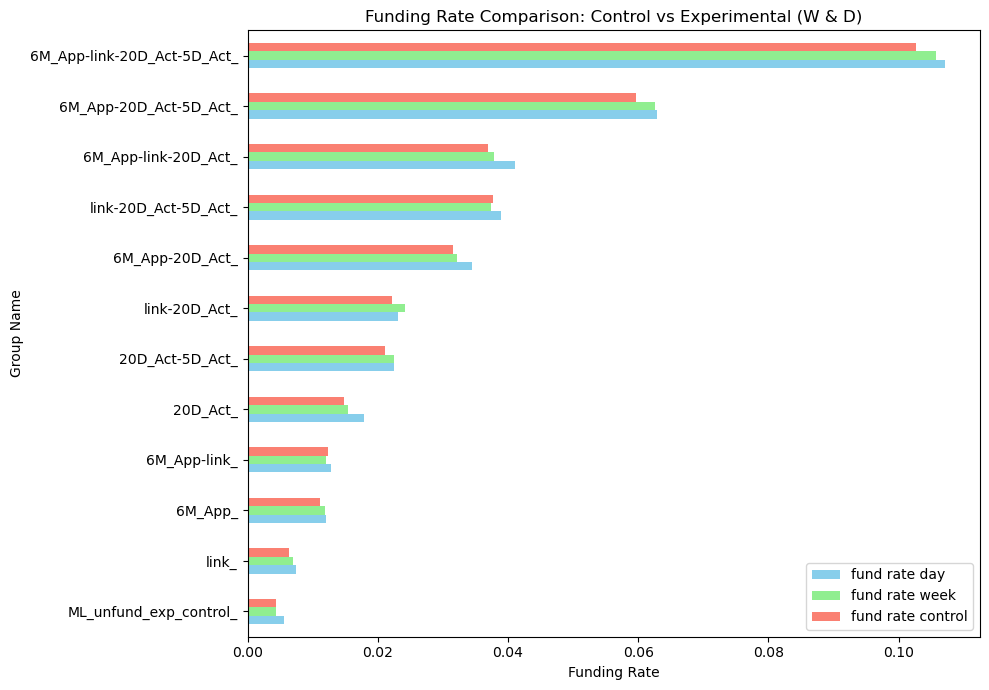

In [ ]:
#plot result from the previous result
result_df.set_index('segment', inplace=True)
result_df.plot(kind='barh', figsize=(10,7), color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Funding Rate')
plt.ylabel('Group Name')
plt.title('Funding Rate Comparison: Control vs Experimental (W & D)')
plt.legend(['fund rate day','fund rate week', 'fund rate control'])
plt.tight_layout()
plt.show()

## two conclusions:
***1. Almost always, fund rate conversion is better when sending email by day.***

***2. Yet sending email to differnt group has different effect sizes.***

## Conduct 12 tests on the 12 segments:

In [196]:
events_converted_success = events.groupby('group_name')['first_funded_at'].apply(lambda x: x.notnull().sum()).reset_index()
control_converted_success = df_control_groups_rate[['group_name', 'num_funded_in_control']]
control_converted_n = df_control_groups_rate[['group_name', 'num_users_in_control']]
events_converted_success = events_converted_success.set_index('group_name')['first_funded_at'].to_dict()
control_converted_success = control_converted_success.set_index('group_name')['num_funded_in_control'].to_dict()
control_converted_n = control_converted_n.set_index('group_name')['num_users_in_control'].to_dict()

In [197]:
p_value_df = []
for key in control_converted_success.keys():
    successes = [events_converted_success[key], control_converted_success[key]]
    n = [20000, control_converted_n[key]]
    z_stat, p_value = proportions_ztest(count=successes, nobs=n, alternative='larger')
    p_value_df.append({'group_name': key, 'z_stat': z_stat, 'p_value': p_value})
p_value_df = pd.DataFrame(p_value_df)

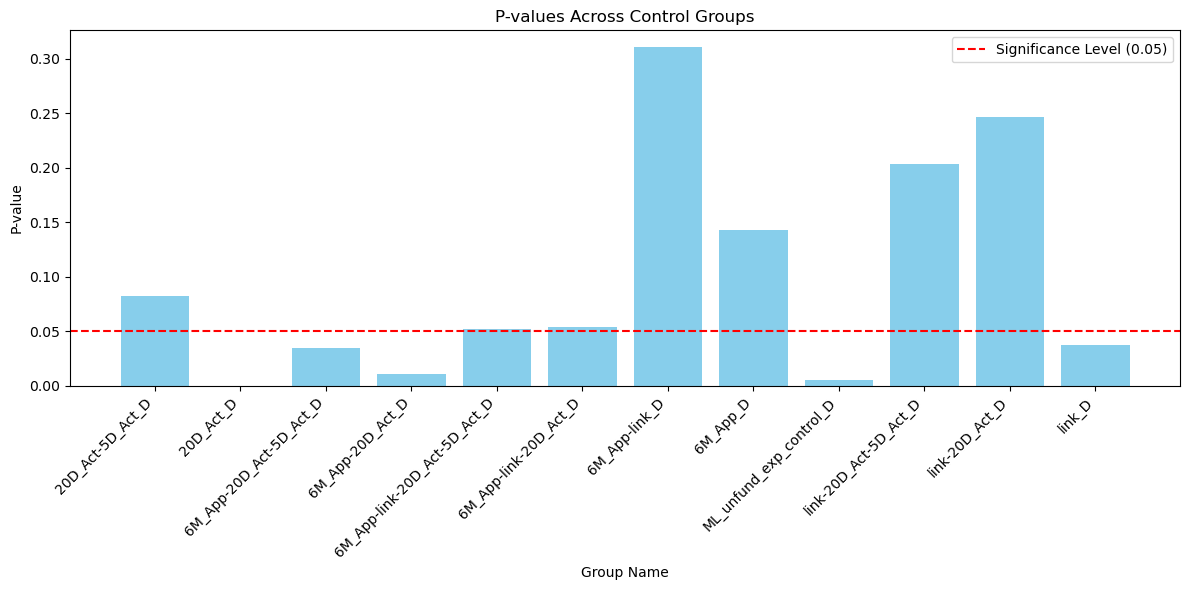

In [198]:
plt.figure(figsize=(12, 6))

plt.bar(p_value_df['group_name'], p_value_df['p_value'], color='skyblue')

plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')

plt.xlabel('Group Name')
plt.ylabel('P-value')
plt.title('P-values Across Control Groups')

plt.xticks(rotation=45, ha='right')

plt.legend()

plt.tight_layout()
plt.show()

#### According to our tests, sending emails by day is proved to be lifting funde rate in these five segmetns:
Those who
1. have had a revent activity in 20 days (20D_Act)
2. are approved in 6 mouths, unlinked, active in recent 20 days, and involved in a trade in the recent 5 days (6M_App-20D_Act-5D_Act)
3. are approved in 6 mouths, unlinked, active in recent 20 days (6M_App-20D_Act)
4. are not approved recently, not linked, not active through an activity or trade (ML_unfund_exp_control)
5. are only linked (link)

### ***Note importantly it's not the case that previously linked segments have smaller p value. This is an important lesson for us. We have to explore the linking behavior of the experiment to understand why groups that are linked which are supposedly easier to fund actually did not improve in fund rate:***


-  **Link Rate vs. Control:**
  - Percentage of users who successfully link their bank account between the experimental and control groups.



In [200]:
#segments with keyword link implies the account is already linked. We would explore link rate in every other segment. 
experiment_link_rate = events[~events['group_name'].str.contains('link')].groupby('group_name')['first_linked_bank_account_at'].apply(lambda x:x.notnull().mean()).sort_values().reset_index()
experiment_link_rate['email scheme'] = experiment_link_rate['group_name'].apply(lambda x:x[-1])
experiment_link_rate['segment'] = experiment_link_rate['group_name'].apply(lambda x:x[:-1])
control_link_rate = df_control_groups_rate[['group_name', 'link_rate_in_control']]
control_link_rate['segment'] = control_link_rate['group_name'].apply(lambda x:x[:-1])
pivot_link_rate = pd.pivot_table(experiment_link_rate,
                                 index = 'segment',
                                 columns='email scheme',
                                 values='first_linked_bank_account_at').sort_values(by='D')
lr_final = pd.merge(pivot_link_rate, control_link_rate, on = 'segment').drop(columns='group_name')
lr_final.columns = ['segment', 'link rate day', 'link rate week', 'link rate control']

/var/folders/rh/vy76y4gj5gzfn44h6hqb986r0000gn/T/ipykernel_24968/3177358621.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_link_rate['segment'] = control_link_rate['group_name'].apply(lambda x:x[:-1])


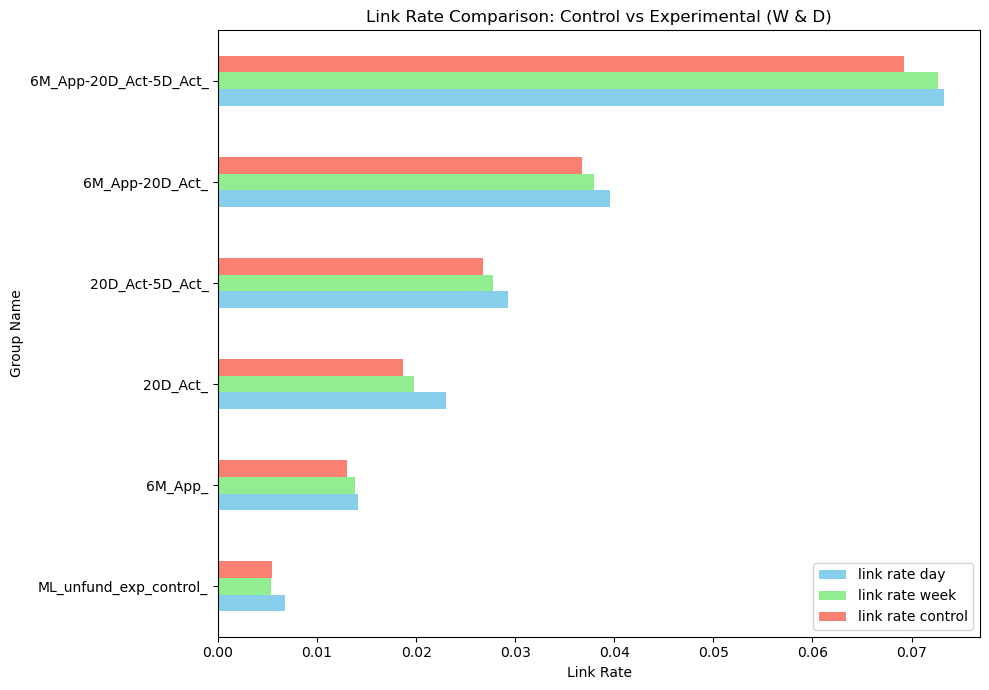

In [214]:
#plot result from the previous result
lr_final.set_index('segment', inplace=True)
lr_final.plot(kind='barh', figsize=(10,7), color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Link Rate')
plt.ylabel('Group Name')
plt.title('Link Rate Comparison: Control vs Experimental (W & D)')
plt.legend(['link rate day', 'link rate week', 'link rate control'])
plt.tight_layout()
plt.show()

### Similar conclusion: daily emails are more indusive of linking behavior. There seems to be big and small effect size to be further tested on. 
### P test on the 6 unlinked group for whether link rate increase is statistically significant:

In [209]:
event_link_success = events[(~events['group_name'].str.contains('link')) & (events['email_strat']=='D')].groupby('group_name')['first_linked_bank_account_at'].apply(lambda x:x.notnull().sum()).reset_index()
control_link_success = df_control_groups_rate[~df_control_groups_rate['group_name'].str.contains('link')][['group_name', 'num_link_in_control']]
control_link_n = df_control_groups_rate[~df_control_groups_rate['group_name'].str.contains('link')][['group_name', 'num_users_in_control']]
event_link_success = event_link_success.set_index('group_name')['first_linked_bank_account_at'].to_dict()
control_link_success = control_link_success.set_index('group_name')['num_link_in_control'].to_dict()
control_link_n = control_link_n.set_index('group_name')['num_users_in_control'].to_dict()

In [213]:
p_value_df_lr = []
for key in control_link_success.keys():
    successes = [event_link_success[key], control_link_success[key]]
    n = [20000, control_link_n[key]]
    z_stat, p_value = proportions_ztest(count=successes, nobs=n, alternative='larger')
    p_value_df_lr.append({'group_name': key, 'z_stat': z_stat, 'p_value': p_value})
p_value_df_lr = pd.DataFrame(p_value_df_lr)

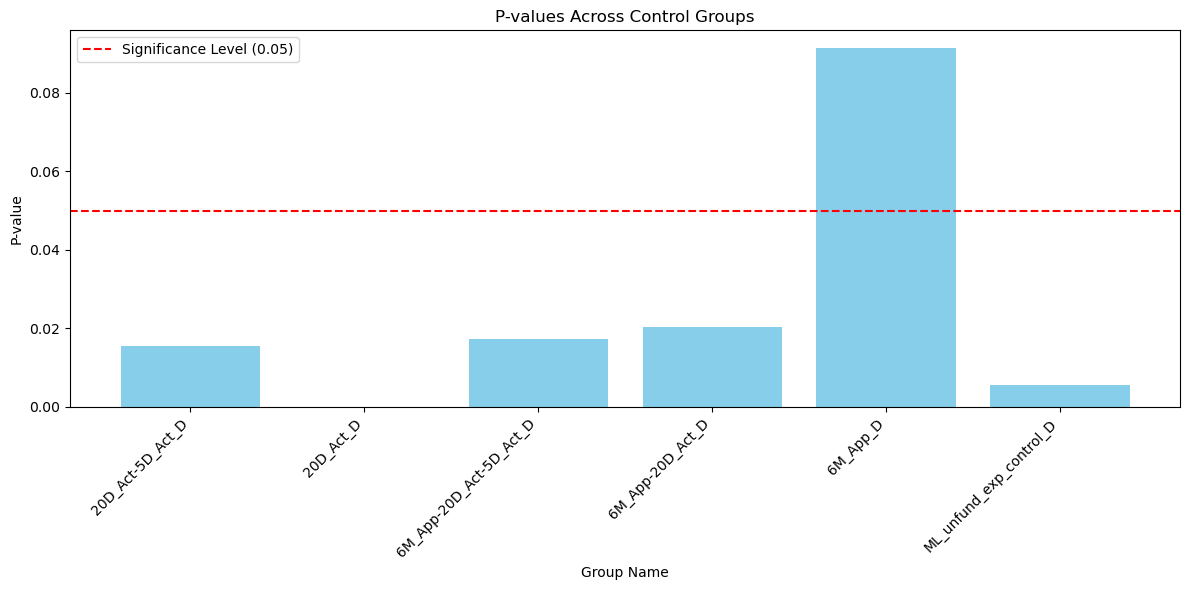

In [215]:
plt.figure(figsize=(12, 6))

plt.bar(p_value_df_lr['group_name'], p_value_df_lr['p_value'], color='skyblue')

plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')

plt.xlabel('Group Name')
plt.ylabel('P-value')
plt.title('P-values Across Control Groups')

plt.xticks(rotation=45, ha='right')

plt.legend()

plt.tight_layout()
plt.show()

#### we see that ***link rate moves with fund rate*** for previously unlinked segments beside 20D_Act-5D_Act_D. It looks like ***the more effect size there is to increase link rate the more fund fund rate improves.***
#### Interestingly, although email by day is not significant for the group 20D_Act-5D_Act_D in fund rate but the linked rate increase is statistically significant; for the segment 6M_App_D, it is not significant for both fund rate and link rate. we might want to devise alternative approach for this group. And for 20D_Act-5D_Act_D, it signifies a direction to improve the emails, to bundle up the motivation for linknig and funding so that those who linked also fund. 

### ***Now, to furthur support this new direction of action, we want to address why already linked accounts have suprisingly less fund rate by looking at the funding conpletion.***

- The segment 6M_App-20D_Act_D is not shown to statistically improve for both link and fund rate. 
- For all of the already linked groups besides one, the fund rate has not been shown to statistically improve. That one expetion is accounts that are only linked but there are no recent activities. We say that those who are linked before but did not fund right away are not easily persuaded by emails, especially if they have recent activity and are linked. It can be seen as having some reason to choose not to fund, whereas if a person is only linked with no recent activities, this person might be reminded of the app and then easily fund the already linked account.
- In the later part, we see that most newly gained users are funded on the same day of being linked. These previously linked accounts being not statistically significant mean that if it is not funded on the day the account is linked. It is less likely for the accounts to be funded at least through emails.

- **Funding Completion:**
  - Percentage of users who funded their account after linking.


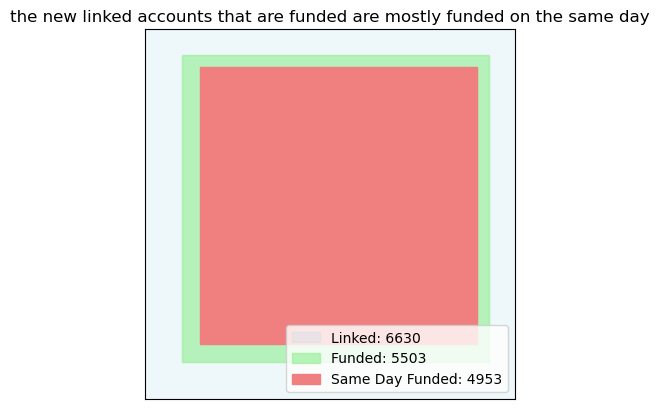

In [217]:
import matplotlib.patches as patches

# Define the data
linked_accounts = events[(events['first_linked_bank_account_at'] > starting_day)].shape[0]
funded_accounts = events[events['first_funded_at'].notnull() &  (events['first_linked_bank_account_at'] > starting_day)].shape[0]
same_day_funded = events[(events['first_funded_at'].dt.date == events['first_linked_bank_account_at'].dt.date) & events['first_funded_at'].notnull() & (events['first_linked_bank_account_at'] > starting_day)].shape[0]

# Define the sizes for the squares (relative proportions)
linked_square_size = 1  # Largest square
funded_square_size = funded_accounts / linked_accounts  # Relative size of funded square
same_day_funded_square_size = same_day_funded / linked_accounts  # Relative size of same day funded square

# Create the figure and axis
fig, ax = plt.subplots()

# Create the largest square (Linked Accounts)
linked_square = patches.Rectangle((0, 0), linked_square_size, linked_square_size, color='lightblue', label=f'Linked: {linked_accounts}', alpha=0.2)

# Create the smaller square inside it (Funded Accounts)
funded_square = patches.Rectangle((0.1, 0.1), funded_square_size, funded_square_size, color='lightgreen', label=f'Funded: {funded_accounts}', alpha=0.6)

# Create the smallest square inside (Same Day Funded)
same_day_funded_square = patches.Rectangle((0.15, 0.15), same_day_funded_square_size, same_day_funded_square_size, color='lightcoral', label=f'Same Day Funded: {same_day_funded}', alpha=1)

# Add the squares to the plot
ax.add_patch(linked_square)
ax.add_patch(funded_square)
ax.add_patch(same_day_funded_square)

# Set limits and aspect ratio
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')

# Add a legend
plt.legend(loc="lower right")
plt.title('the new linked accounts that are funded are mostly funded on the same day')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## this is an importatn discovery. Those who are linked are 80% possible to fund and out of those who linked and funded over 90% are funded on the same day that the account was linked. Thus, to improve fund rate it is important to focus on motivating users to link and immediately fund the accounts. Otherwise, the accounts are likely not going to be funded in a while as shown in our p tests that all linked segments are not statistically significant in improving fund rate. 
## New Metric Definition: First Day of Link Conversion Rate
## Link rate is also important as a result since the control groups for linked accounts show that they are segments with the highest fund rate, although sending emails doesn't prove statistically useful:

In [ ]:
ratio_for_funded_linked = events[events['first_funded_at'] >= events['first_linked_bank_account_at']].shape[0]/events[events['first_linked_bank_account_at'].notnull()].shape[0]
ratio_for_funded_overall = events[events['first_funded_at'].notnull()].shape[0]/events.shape[0]
ratio_for_funded_notlinked = events[events['first_funded_at'].notnull() & events['first_linked_bank_account_at'].isnull()].shape[0]/events[events['first_linked_bank_account_at'].isnull()].shape[0]

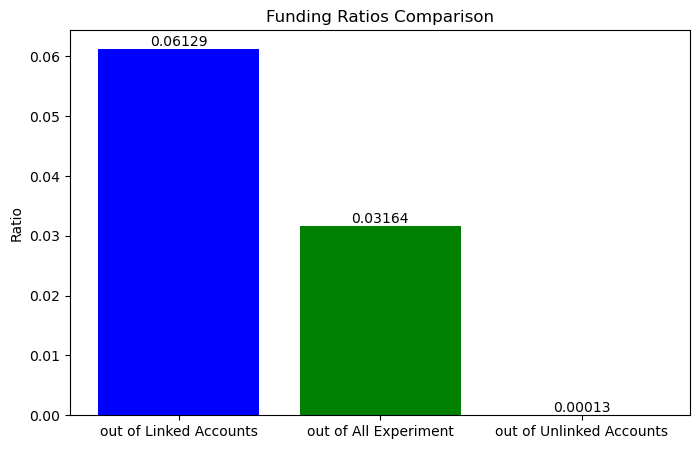

In [ ]:
ratios = [ratio_for_funded_linked, ratio_for_funded_overall, ratio_for_funded_notlinked]
labels = ['out of Linked Accounts', 'out of All Experiment', 'out of Unlinked Accounts']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, ratios, color=['blue', 'green', 'red'])


plt.title('Funding Ratios Comparison')
plt.ylabel('Ratio')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 5), ha='center', va='bottom')

plt.show()

- **Implying that mid funnel improvement to better link rate is going to be very effective.**
- **Notice that our expriment group doesn't represent the actually situation. More linked accounts are being selected due to the way our segemntation works. there should be as much as 50% of linked accounts irl**

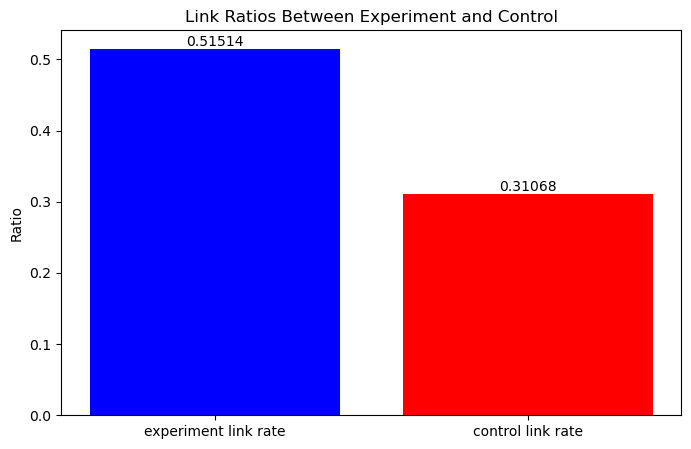

In [ ]:
experiment_link_rate = events[events['first_linked_bank_account_at'].notnull()].shape[0]/events.shape[0]
control_link_rate = df_control_groups_rate['num_link_in_control'].sum()/df_control_groups_rate['num_users_in_control'].sum()
ratios = [experiment_link_rate, control_link_rate]
labels = ['experiment link rate', 'control link rate']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, ratios, color=['blue', 'red'])


plt.title('Link Ratios Between Experiment and Control')
plt.ylabel('Ratio')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 5), ha='center', va='bottom')

## ***Conclusion***
- sending emails improves fund rate statistically; by day is better than by week by an amount much greater than the friction
- within segments, sending emails improves funding rate w.r.t. control group in previously unlinked groups (with one exception)
- linked rate in these groups also increased statistically (with one exception)
-  90% of the time: the newly linked accounts that are also funded are funded on the day it was linked 
-  previously linked accounts has the highest fund rate but sending emails don't make a statistical difference
- for future, a new metric to be aware when devising emails is first day of link conversion rate.

**exception groups:**
- 20D_Act-5D_Act_D improved linked rate but not fund rate sending emails. 
- link is the only group be improve fund rate by sending emails while being previously linked

- 6M_App_D is not an exception to previous conclusions but instersting that sending email doesn't improve link rate nor fund rate



- **Trading Activity:**
  - **1 Trade:** Percentage of users who completed at least 1 trade.
  - **2+ Trades:** Percentage of users who completed 2 or more trades.

In [231]:
valid_activity = events[events.loc[:,'5d_trading_avg_event_count':'1d_non_trading_avg_event_count'].notna().any(axis=1)].loc[:,['5d_trading_avg_event_count', '2d_non_trading_avg_event_count',
       '20d_trading_avg_event_count', '8d_non_trading_avg_event_count',
       '1d_trading_avg_event_count', '1d_non_trading_avg_event_count', 'first_funded_at']]
no_activity = events[~events.index.isin(valid_activity.index)].loc[:,['5d_trading_avg_event_count', '2d_non_trading_avg_event_count',
       '20d_trading_avg_event_count', '8d_non_trading_avg_event_count',
       '1d_trading_avg_event_count', '1d_non_trading_avg_event_count', 'first_funded_at']]



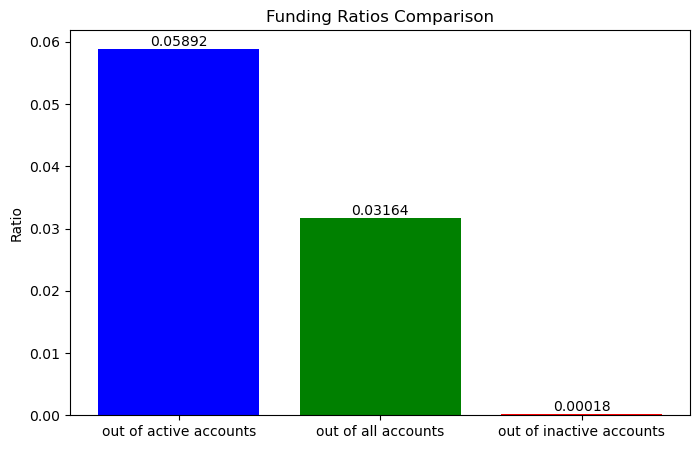

In [242]:
x_labels = ['out of active accounts', 'out of all accounts', 'out of inactive accounts']

y_values = [valid_activity[valid_activity['first_funded_at'].notnull()].shape[0]/valid_activity.shape[0], events[events['first_funded_at'].notnull()].shape[0]/events.shape[0], 
            no_activity[no_activity['first_funded_at'].notnull()].shape[0]/no_activity.shape[0]]

plt.figure(figsize=(8, 5))
bars = plt.bar(x_labels, y_values, color=['blue', 'green', 'red'])


plt.title('Funding Ratios Comparison')
plt.ylabel('Ratio')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 5), ha='center', va='bottom')

plt.show()


#### fund rate depends on activities a lot, very similar to the link rate vs fund rate comparison. 

<Axes: >

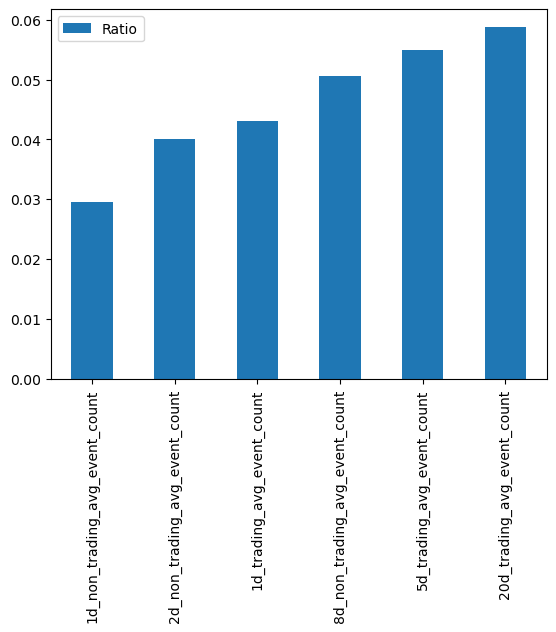

In [247]:
activity_dict = {}
for column in valid_activity.columns:
    if column == 'first_funded_at':
        continue
    activity_dict[column] = valid_activity[(valid_activity[column].notnull()) & (valid_activity['first_funded_at'].notnull())].shape[0]/valid_activity.shape[0]
# Convert the dictionary to a DataFrame
df_ratios = pd.DataFrame.from_dict(activity_dict, orient='index', columns=['Ratio']).sort_values(by='Ratio')

# Plot the ratios
df_ratios.plot(kind='bar')


/var/folders/rh/vy76y4gj5gzfn44h6hqb986r0000gn/T/ipykernel_24968/3813565367.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)  # Fill missing values with 0


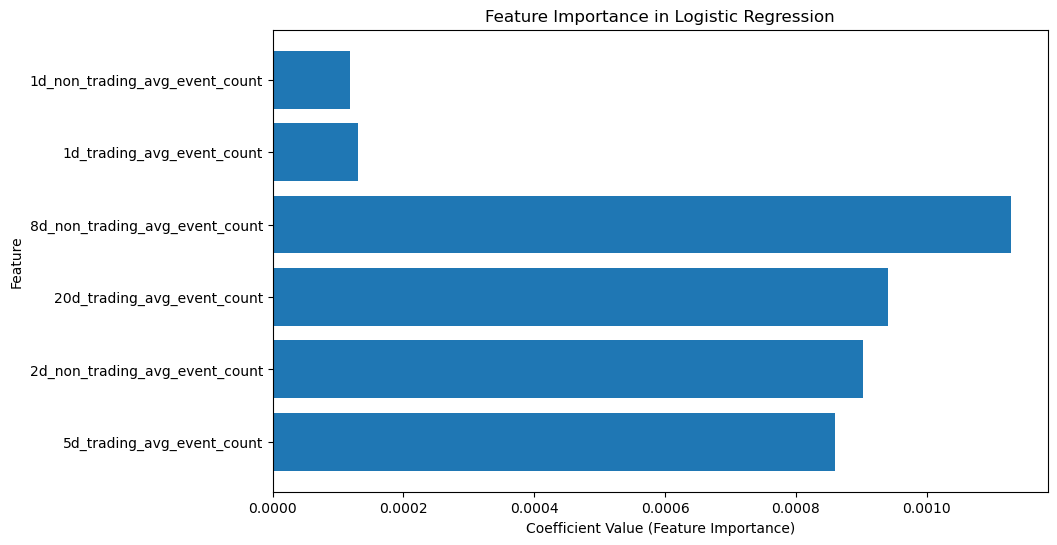

In [262]:

valid_activity['first_funded_target'] = valid_activity['first_funded_at'].notna().astype(int)


feature_columns = [
    '5d_trading_avg_event_count', '2d_non_trading_avg_event_count', '20d_trading_avg_event_count',
    '8d_non_trading_avg_event_count', '1d_trading_avg_event_count', '1d_non_trading_avg_event_count'
]
X = valid_activity[feature_columns]
X.fillna(0, inplace=True)  # Fill missing values with 0
y = valid_activity.loc[:,'first_funded_target']  # Select the corresponding target rows


# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X, y)

# Get the coefficients (for binary classification, it's a 1D array)
coefficients = model.coef_[0]  # Extract the first (and only) row since it's a binary classification

# Plot the coefficients (feature importance)
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, coefficients)
plt.xlabel('Coefficient Value (Feature Importance)')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.show()

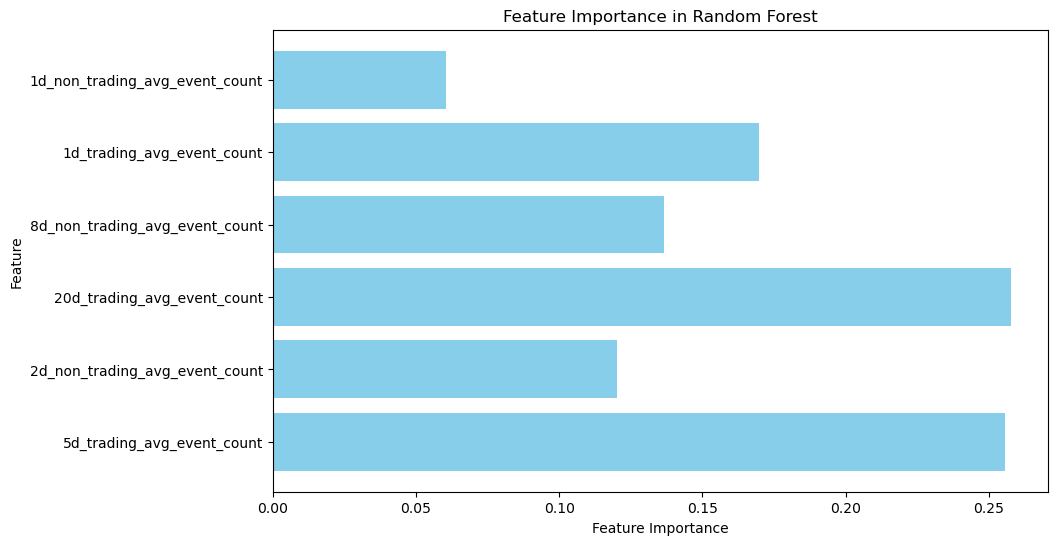

In [258]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=1017) 
rf_model.fit(X, y)

# Get the feature importances
rf_feature_importances = rf_model.feature_importances_

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, rf_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.show()

#### Building classifiers to predict whether an account is funded using the trading and non-trading activity columns, I leverage feature importance to see how different trading activities influence the prediction. Using both logistic linear regression and random forest classifier, I reached a consistent interpretation on the activity types. 
#### Both models show that trading or non-trading activities, no matter the span of time, trading activities are more important in causing a funding event. Both models also show that longer span of activities, for instance 20 day trading count, is more important than shorter span of activities such as 5 day trading count. 
	
#### Combined with encouraging linking, motivating for activities on the app is another aspect of improvement. For better fund rate performance, we could target these mid funnel aspects in addition to actions to the bottom of the funnel. Mid-funnel actions could be to improve link rate and stimulate activeness of current linked users. Bottom-funnel could be to send emails that generate the most funding events such as email 10 in this experiment and to strengthen the bundle of actions to link and immediately fund. 

#### Lastly, there is a considerable constraint to the activity analysis. There are limited ways to tell whether an action is spontaneous or induced by the emails we sent. We have no access to activity data from the control group. This is a consideration for future data collection. 
